## Setup

### GPU Usage

In [1]:
!nvidia-smi
!nvidia-smi -L

Tue Jan 21 12:03:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4080        Off |   00000000:2D:00.0  On |                  N/A |
| 30%   44C    P2            120W /  320W |   14607MiB /  16376MiB |    100%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

GPU 0: NVIDIA GeForce RTX 4080 (UUID: GPU-6e8dfb2b-0d26-b53a-4efe-09e7daefc861)


### Imports

In [2]:
%load_ext autoreload
%autoreload 2

from time_series_generation import *
from phid import *
from graph_theoretical_analysis import *
from cognitive_tasks_analysis import *
from cognitive_tasks_vs_syn_red_analysis import *
from lda import *
from random_walk_time_series import *
from model_comparisons import *
from hf_token import TOKEN

from huggingface_hub import login
from transformers import AutoTokenizer, AutoConfig 
import seaborn as sns
import matplotlib.pyplot as plt

### Loading the Model

In [3]:
if constants.LOAD_MODEL:
    device = torch.device("cuda")
    login(token = TOKEN)
    attn_implementation="eager" # GEMMA_ATTENTION_CLASSES = {"eager": GemmaAttention, "flash_attention_2": GemmaFlashAttention2, "sdpa": GemmaSdpaAttention,}


    # Load the configuration and modify it
    model_config = AutoConfig.from_pretrained(constants.MODEL_NAME, cache_dir=constants.CACHE_DIR_BITBUCKET)
    model_config._attn_implementation = attn_implementation  # Custom attention parameter

    # Load the tokenizer and model with the modified configuration
    tokenizer = AutoTokenizer.from_pretrained(constants.MODEL_NAME, cache_dir=constants.CACHE_DIR_BITBUCKET)
    model = AutoModelForCausalLM.from_pretrained(
        constants.MODEL_NAME,
        cache_dir=constants.CACHE_DIR_BITBUCKET,
        device_map='auto',
        attn_implementation=attn_implementation, # Make sure to use the adequate attention layer in order to 
        config=model_config,  # Use the modified config
    )

    model.eval()
    print("Loaded Model Name: ", model.config.name_or_path)
    print("Model: ", model)
    print("Attention Layers Implementation: ", model.config._attn_implementation)
    print(f"Number of layers: {constants.NUM_LAYERS}")
    print(f"Number of attention heads per layer: {constants.NUM_HEADS_PER_LAYER}")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded Model Name:  google/gemma-2-2b-it
Model:  Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2304, bias=False)
          (rotary_emb): Gemma2RotaryEmbedding()
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (pre_f

### Simple Prompt

In [4]:
if constants.LOAD_MODEL:
    prompt = "What is the sum of 457 and 674? Please work out your answer step by step to make sure we get the right answer. "
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.generate(
            inputs['input_ids'],
            max_new_tokens=100,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            attention_mask=inputs['attention_mask']  # Provide attention mask for reliable results
        )
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(generated_text)

What is the sum of 457 and 674? Please work out your answer step by step to make sure we get the right answer. 

**Step 1:** Write the numbers vertically, aligning the units digits.

```
  457
+ 674
----
```

**Step 2:** Add the units digits, 7 + 4 = 11. Write down the 1 and carry over the 1.

```
  457
+ 674
----
    1
```

**Step 3:** Add the tens digits, 5 +


### Autoregresive Sampling

In [5]:
if constants.LOAD_MODEL:
    # prompt = "Find the grammatical error in the following sentence: She go to the store and buy some milk"
    prompt = "What is the sum of 457 and 674?"# Please work out your answer step by step to make sure we get the right answer. "
    # prompt = "How much is 2 multiplied by 8?"
    # prompt = "Write a very creative story about a dragon that lives in a cave and breathes fire"
    num_tokens_to_generate = 100
    generated_text, attention_params = generate_text_with_attention(model, tokenizer, num_tokens_to_generate, device, prompt=prompt, 
        temperature=0.3, modified_output_attentions=constants.MODIFIED_OUTPUT_ATTENTIONS)
    time_series = compute_attention_metrics_norms(attention_params, constants.METRICS_TRANSFORMER, num_tokens_to_generate, aggregation_type='norm')
    print(attention_params[constants.ATTENTION_MEASURE].shape)
    print(generated_text)

torch.Size([26, 8, 115, 256])
What is the sum of 457 and 674?

Here's how to solve it:

* **Line up the numbers:**
   ```
   457
 + 674
   ----
   ```

* **Add the ones place:** 7 + 4 = 11. Write down the 1 and carry over the 1.

* **Add the tens place:** 5 + 7 + 1 (carry-over) = 13. Write down the 3 and carry


## Attention Head Ablation Experiments

In [4]:
import ablation_studies
import utils

#### Recording Logits in Autoregressive Sampling

In [5]:
# No ablation
model.reset_ablated_heads()
model.print_ablated_heads()

prompt = constants.PROMPTS['emotional_intelligence_and_social_cognition'][0]
num_tokens_to_generate = 30

generated_text, logits_list, generated_ids = ablation_studies.generate_text_with_logits(model, tokenizer, num_tokens_to_generate=num_tokens_to_generate, 
                                                                         device=device, prompt=prompt, temperature=0.0)
print(f'Lenght of logits_list: {len(logits_list)}, Shape of logits: {logits_list.shape}')
print(f'Shpae of the generated_ids: {generated_ids.shape}')
print(generated_text)

No attention heads have been ablated
Lenght of logits_list: 30, Shape of logits: torch.Size([30, 1, 256000])
Shpae of the generated_ids: torch.Size([1, 49])
Write a dialogue between two characters where one comforts the other after a loss, demonstrating empathy.

**Characters:**

* **Liam:** A young man, recently lost his job.
* **Sarah:** Liam's friend, a supportive


### Computing Divergence of Ablated Model

In [6]:
ablated_attention_heads = {
    0: [], 1: [1,2,3,4,5], 2: [], 3: [1,2,5,6], 4: [3], 5: [1,6,7], 6: [1,2,3,7], 7: [1,], 8: [0,1,2,3,4,5,6,7], 9: [0,1,2,3,4,5,6,7], 10: [0, 1,2,3,4,5,6,7], 11: [], 12: [], 13: [], 14: [], 15: [0,1,2,3,4,5,6,7], 16: [], 17: []        
}

ablated_logits, divergence_list, generated_text = ablation_studies.generate_with_teacher_forcing_ablated(model, tokenizer, non_ablated_token_ids=generated_ids, 
    non_ablated_logits=logits_list, device=device, temperature=0.0, ablated_attention_heads=ablated_attention_heads,verbose=False)

print(f'Divergence Sum: {sum(divergence_list)}')
print(generated_text)

Divergence Sum: 25.07286795665277
Write a dialogue between two characters where one comforts the other after a loss, demonstrating empathy.

**Character:**

* **Elena:** A young man, recently lost his job,
* **Sarah:** A iss friend, recently young


### Batching

In [12]:
# No ablation
model.reset_ablated_heads()
model.print_ablated_heads()

prompts = constants.PROMPTS['simple_maths']
num_tokens_to_generate = 15

generated_texts, non_ablated_logits, non_ablated_token_ids = ablation_studies.generate_text_with_logits_batch(model, tokenizer, num_tokens_to_generate=num_tokens_to_generate, 
                                                                         device=device, prompts=prompts, temperature=0.0)
print(f'Lenght of logits_list: {len(logits_list)}, Shape of logits: {logits_list.shape}')
print(f'Length of generated_ids: {len(generated_ids)}, Shape of the generated_ids: {generated_ids.shape}')
print(generated_texts)

No attention heads have been ablated
Lenght of logits_list: 50, Shape of logits: torch.Size([50, 1, 256000])
Length of generated_ids: 1, Shape of the generated_ids: torch.Size([1, 75])
['\n\nYou would have **10** apples left. \n', "\n\nHere's how to solve the problem:\n\n**1. Define", "\n\nHere's how to solve it:\n\n* **Daily reading:**", "\n\nHere's how to solve it:\n\n* **Speed:** The", "\n\n**Here's how to solve it:**\n\n* **Start with", "\n\nHere's how to solve it:\n\n* **Cost per pencil", "\n\n**Here's how to solve the problem:**\n\n* **Convert", "\n\nHere's how to solve it:\n\n* **Find the total", "\n\nHere's how to solve it:\n\n1. **Divide ", "\n\nHere's how to solve it:\n\n* **Divide the total"]


In [13]:
num_tokens_to_generate = 20
ablated_attention_heads = {
    0: [], 1: [1,2,3,4,5], 2: [], 3: [1,2,5,6], 4: [3], 5: [1,6,7], 6: [1,2,3,7], 7: [1,], 8: [0,1,2,3,4,5,6,7], 9: [0,1,2,3,4,5,6,7], 10: [0, 1,2,3,4,5,6,7], 11: [], 12: [], 13: [], 14: [], 15: [0,1,2,3,4,5,6,7], 16: [], 17: []        
}

ablated_logits, divergence_list, generated_texts = ablation_studies.generate_with_teacher_forcing_ablated_batch(model, tokenizer, prompts, non_ablated_token_ids=non_ablated_token_ids, 
    non_ablated_logits=non_ablated_logits, device=device, temperature=0.0, ablated_attention_heads=ablated_attention_heads,verbose=True)

print(f'Divergence Sum: {[sum(divergence) for divergence in divergence_list]}')
print(generated_texts)

Batch size: 10
Prompt lengths: [22, 30, 25, 24, 25, 19, 29, 28, 22, 27]
Generation lengths: [15, 15, 15, 15, 15, 15, 15, 15, 15, 15]
Max generation length: 15
Divergence Sum: [tensor(6.4141, device='cuda:0'), tensor(3.3999, device='cuda:0'), tensor(11.5187, device='cuda:0'), tensor(3.6570, device='cuda:0'), tensor(5.4447, device='cuda:0'), tensor(7.1211, device='cuda:0'), tensor(7.4390, device='cuda:0'), tensor(11.1338, device='cuda:0'), tensor(2.7535, device='cuda:0'), tensor(7.3804, device='cuda:0')]
['If you have 15 apples and you give away 5, how many do you have left?\n\nHere have have 10** apples left. \n\n', "A rectangle's length is twice its width. If the rectangle's perimeter is 36 meters, what are its length and width?\n\nHere's how to solve it problem:\n\n**1.  ", "You read 45 pages of a book each day. How many pages will you have read after 7 days?\n\n\nHere's the to solve it:\n\n* **Day progress:**", "If a train travels 60 miles in 1 hour, how far will it travel in 3 hours

### Ablate Most Synergistic Heads First

In [7]:
prompt_category_name = 'average_prompts'
global_matrices, synergy_matrices, redundancy_matrices = load_matrices(base_save_path=constants.MATRICES_DIR + prompt_category_name + '/' + prompt_category_name + '.pt')
averages = calculate_average_synergy_redundancies_per_head(synergy_matrices, redundancy_matrices, within_layer=False)
gradient_ranks = compute_gradient_rank(averages)

### Gradient Ranks ###
gradient_ranks = gradient_ranks[constants.ATTENTION_MEASURE]
sorted_heads_by_rank = sorted(gradient_ranks.items(), key=lambda x: x[1], reverse=True)
syn_minus_red_ranked_heads = [utils.get_layer_and_head(head_num) for head_num, _ in sorted_heads_by_rank]

### Synergy and Redundancy Ranks ###
synergies, redundancies = averages[constants.ATTENTION_MEASURE]["synergy"], averages[constants.ATTENTION_MEASURE]["redundancy"]

synergies_dict = {i+1: synergies[i] for i in range(len(synergies))}
redundancies_dict = {i+1: redundancies[i] for i in range(len(redundancies))}

synergy_ranks = {i: rank for rank, (i, _) in enumerate(sorted(synergies_dict.items(), key=lambda x: x[1], reverse=True))}
redundancy_ranks = {i: rank for rank, (i, _) in enumerate(sorted(redundancies_dict.items(), key=lambda x: x[1], reverse=True))}

sorted_heads_by_synergy = sorted(synergies_dict.items(), key=lambda x: x[1], reverse=True)
sorted_heads_by_redundancy = sorted(redundancies_dict.items(), key=lambda x: x[1], reverse=True)

synergy_ranked_heads = [utils.get_layer_and_head(head_num) for head_num, _ in sorted_heads_by_synergy]
redundancy_ranked_heads = [utils.get_layer_and_head(head_num) for head_num, _ in sorted_heads_by_redundancy]

head_rankings = {"synergy": synergy_ranked_heads, "redundancy": redundancy_ranked_heads, "syn_minus_red": syn_minus_red_ranked_heads}
print(head_rankings)

{'synergy': [(16, 1), (14, 1), (16, 7), (10, 6), (15, 3), (6, 4), (5, 7), (8, 2), (19, 5), (6, 5), (16, 4), (14, 7), (5, 6), (12, 7), (13, 7), (5, 5), (14, 5), (15, 1), (17, 0), (13, 6), (7, 2), (10, 4), (4, 7), (14, 0), (10, 3), (17, 2), (17, 4), (10, 7), (11, 2), (16, 2), (13, 4), (16, 6), (17, 3), (11, 0), (4, 4), (10, 2), (13, 0), (11, 3), (8, 0), (12, 4), (11, 7), (12, 5), (5, 3), (11, 1), (5, 1), (11, 6), (16, 3), (14, 3), (9, 7), (13, 3), (7, 7), (12, 1), (8, 1), (6, 6), (15, 0), (13, 2), (9, 6), (7, 1), (13, 1), (14, 4), (4, 2), (9, 2), (18, 3), (8, 5), (20, 5), (8, 6), (18, 5), (17, 5), (12, 0), (14, 6), (6, 2), (22, 3), (11, 4), (16, 0), (7, 6), (6, 7), (8, 4), (18, 7), (12, 6), (4, 0), (12, 2), (10, 1), (14, 2), (12, 3), (16, 5), (25, 0), (18, 4), (13, 5), (19, 1), (7, 4), (4, 5), (18, 6), (2, 7), (17, 1), (23, 5), (19, 0), (7, 3), (6, 1), (15, 7), (22, 6), (20, 2), (9, 3), (25, 5), (9, 1), (20, 4), (18, 2), (1, 1), (15, 5), (8, 7), (7, 5), (10, 5), (17, 6), (20, 6), (9, 0),

In [8]:
import random, os, json
import matplotlib.pyplot as plt

num_tokens_to_generate = 20
ablation_ranking_method = constants.ABLATIONS_RANKING_METHOD
num_random_ablations = 2  # Number of iterations to repeat the random ablation process
num_heads_skip_per_iteration = 20  # The fixed number of heads to ablate in each iteration

# The resulting divergence trajectories for random and gradient rank-based ablations for each prompt
# The first key is the prompt category name, and the second key is the prompt number, third is whether it is random or gradient 
# The value is a list of divergence trajectories for each iteration
divergence_results = {
    "divergences": {prompt_category_name: {prompt_num: {'random': [], 'gradient': []} for prompt_num in range(len(constants.PROMPTS[prompt_category_name]))} for prompt_category_name in constants.PROMPTS.keys()},
    "list_heads_ablated": [i for i in range(0, constants.NUM_TOTAL_HEADS, num_heads_skip_per_iteration)],
}

n_prompts_per_category = 1#len(constants.PROMPTS[list(constants.PROMPTS.keys())[0]])
for prompt_num in range(n_prompts_per_category):
    for prompt_category_name, prompt_list in constants.PROMPTS.items():
        prompt = prompt_list[prompt_num]

        ##### Run the Non-Ablated Model #####
        model.reset_ablated_heads()
        model.print_ablated_heads()
        generated_text, logits_list, generated_ids = ablation_studies.generate_text_with_logits(
            model, 
            tokenizer, 
            num_tokens_to_generate=num_tokens_to_generate,
            device=device, 
            prompt=prompt, 
            temperature=1.5
        )
        print(generated_text)

        ##### Run the Rank-Based Ablation #####
        # Loop over the number of steps required to ablate all heads
        for i in range(0, constants.NUM_TOTAL_HEADS, num_heads_skip_per_iteration):
            # Get the current list of heads to ablate
            current_heads_to_ablated = head_rankings[ablation_ranking_method][:i + num_heads_skip_per_iteration]

            # Initialize the ablated_attention_heads dictionary
            ablated_attention_heads = {}
            for layer, head in current_heads_to_ablated:
                if layer not in ablated_attention_heads:
                    ablated_attention_heads[layer] = []
                ablated_attention_heads[layer].append(head)

            # Generate the output with the current ablated heads
            ablated_logits, divergence, generated_text = ablation_studies.generate_with_teacher_forcing_ablated(
                model,
                tokenizer,
                non_ablated_token_ids=generated_ids,
                non_ablated_logits=logits_list,
                device=device,
                temperature=0.0,
                ablated_attention_heads=ablated_attention_heads,
                verbose=False
            )

            # Record the sum of divergences
            divergence_results["divergences"][prompt_category_name][prompt_num]['gradient'].append(sum(divergence))

        ##### Run the Random Ablations #####
        for iteration in range(num_random_ablations):
            # Generate a list of all attention heads (layer, head)
            attention_heads_list = [(layer, head) for layer in range(constants.NUM_LAYERS) for head in range(constants.NUM_HEADS_PER_LAYER)]

            # Randomly shuffle the list to determine the ablation order
            random.shuffle(attention_heads_list)

            # Initialize list to record divergences for this iteration
            divergence_list = []

            # Loop over the number of steps required to ablate all heads
            for i in range(0, constants.NUM_TOTAL_HEADS, num_heads_skip_per_iteration):
                # Get the current list of heads to ablate
                current_heads_to_ablated = attention_heads_list[:i + num_heads_skip_per_iteration]

                # Initialize the ablated_attention_heads dictionary
                ablated_attention_heads = {}
                for layer, head in current_heads_to_ablated:
                    if layer not in ablated_attention_heads:
                        ablated_attention_heads[layer] = []
                    ablated_attention_heads[layer].append(head)

                # Call your method to generate the output with the current ablated heads
                ablated_logits, divergence, generated_text = ablation_studies.generate_with_teacher_forcing_ablated(
                    model,
                    tokenizer,
                    non_ablated_token_ids=generated_ids,
                    non_ablated_logits=logits_list,
                    device=device,
                    temperature=0.0,
                    ablated_attention_heads=ablated_attention_heads,
                    verbose=False
                )

                # Record the sum of divergences
                divergence_list.append(sum(divergence))

            # Store the divergence trajectory for this iteration
            divergence_results["divergences"][prompt_category_name][prompt_num]['random'].append(divergence_list)

            # Optional: Print progress for each iteration
            print(f'Completed random ablation iteration {iteration + 1}.')

        
        ##### Save the results to a json file #####
        save_dir = constants.ABLATIONS_DIR + ablation_ranking_method + '/' 
        os.makedirs(save_dir, exist_ok=True)
        with open(save_dir + 'divergence_results.json', 'w') as f:
            json.dump(divergence_results, f)


        ##### PLOTING #####
        # Plot the divergence trajectories for random ablations and gradient rank-based ablation
        plt.figure(figsize=(10, 6))

        # Plot random ablations
        for idx, divergence_trajectory in enumerate(divergence_results["divergences"][prompt_category_name][prompt_num]['random']):
            plt.plot(divergence_results["list_heads_ablated"], divergence_trajectory, marker='o', color='blue', alpha=0.5,
                    label='Random Ablations' if idx == 0 else "")

        # Plot gradient rank-based ablation
        plt.plot(divergence_results["list_heads_ablated"], divergence_results["divergences"][prompt_category_name][prompt_num]['gradient'], marker='o', color='red', label='Gradient Rank Ablations')

        plt.xlabel('Number of Heads Ablated')
        plt.ylabel('Divergence Sum')
        plt.title('Divergence vs. Number of Ablated Attention Heads')
        plt.legend()
        plt.grid(True)
        save_dir = constants.PLOT_ABLATIONS + 'test/' + ablation_ranking_method + '/' + prompt_category_name + '/' 
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(save_dir + str(prompt_num) + '_random_vs_gradient_rank_ablations_divergence_trajectories.png')
        # plt.show()
        plt.close()

No attention heads have been ablated
If you have 15 apples and you give away 5, how many do you have left?

**Answer:** 10

If you give away 5 apples, you will have 
Completed random ablation iteration 1.
Completed random ablation iteration 2.
No attention heads have been ablated
Correct the error: He go to school every day.

The correct sentence is: He goes to school every day.

"Go" is a present
Completed random ablation iteration 1.
Completed random ablation iteration 2.
No attention heads have been ablated
Identify the parts of speech in the sentence: Quickly, the agile cat climbed the tall tree.

**Parts of Speech:**

* **Adverb:** Quickly
* **Pronoun:** the
Completed random ablation iteration 1.
Completed random ablation iteration 2.
No attention heads have been ablated
If it starts raining while the sun is shining, what weather phenomenon might you expect to see?

a) Thunderstorms
b) Rain
c) Fog
d) Lightning

The answer
Completed random ablation iteration 1.
Completed random abl

### Batched Computation

In [12]:
import pickle

# Path to the pickle file
file_path = constants.ABLATIONS_DIR +  constants.ABLATIONS_RANKING_METHOD  + '/divergence_results.pkl'

# Open the pickle file in read-binary mode
with open(file_path, 'rb') as f:
    data = pickle.load(f)

import torch

def get_list_shape(lst):
    """Recursively computes the shape of a nested list."""
    if isinstance(lst, list) and len(lst) > 0:
        return [len(lst)] + get_list_shape(lst[0])  # Check the shape recursively
    elif isinstance(lst, list):
        return [0]  # Empty list has no shape
    else:
        return []  # End recursion if the element is not a list

def print_nested_keys_and_shapes(d, indent=0, show_full_list=False):
    """Recursively prints the keys of a nested dictionary, tensor shapes, and list sizes."""
    if isinstance(d, dict):
        for key, value in d.items():
            print("  " * indent + f"- {key}")
            if isinstance(value, dict):  # If value is a nested dictionary, go deeper
                print_nested_keys_and_shapes(value, indent + 1, show_full_list)
            elif isinstance(value, torch.Tensor):  # Check if it's a tensor and print its shape
                print("  " * (indent + 1) + f"(Tensor with shape: {tuple(value.shape)})")
            elif isinstance(value, list):  # Check if it's a list
                shape = get_list_shape(value)
                if show_full_list:
                    print("  " * (indent + 1) + f"(List with shape: {shape}, Full list: {value})")
                else:
                    print("  " * (indent + 1) + f"(List with shape: {shape})")
            else:  # For other types, print their type
                print("  " * (indent + 1) + f"(Leaf type: {type(value).__name__})")
    elif isinstance(d, torch.Tensor):  # If the top-level object is a tensor
        print("  " * indent + f"(Tensor with shape: {tuple(d.shape)})")
    elif isinstance(d, list):  # If the top-level object is a list
        shape = get_list_shape(d)
        if show_full_list:
            print("  " * indent + f"(List with shape: {shape}, Full list: {d})")
        else:
            print("  " * indent + f"(List with shape: {shape})")
    else:  # For non-dictionary, non-tensor, non-list types
        print("  " * indent + f"(Leaf type: {type(d).__name__})")

# Example Usage
print_nested_keys_and_shapes(data, show_full_list=True)





- divergences
  - simple_maths
    - 0
      - random
        (List with shape: [0], Full list: [])
      - gradient
        (List with shape: [0], Full list: [])
    - 1
      - random
        (List with shape: [0], Full list: [])
      - gradient
        (List with shape: [0], Full list: [])
    - 2
      - random
        (List with shape: [0], Full list: [])
      - gradient
        (List with shape: [0], Full list: [])
    - 3
      - random
        (List with shape: [0], Full list: [])
      - gradient
        (List with shape: [0], Full list: [])
    - 4
      - random
        (List with shape: [0], Full list: [])
      - gradient
        (List with shape: [0], Full list: [])
    - 5
      - random
        (List with shape: [0], Full list: [])
      - gradient
        (List with shape: [0], Full list: [])
    - 6
      - random
        (List with shape: [0], Full list: [])
      - gradient
        (List with shape: [0], Full list: [])
    - 7
      - random
        (List with sha

In [24]:
import random, os, pickle
import matplotlib.pyplot as plt


num_tokens_to_generate = 20
ablation_ranking_method = constants.ABLATIONS_RANKING_METHOD 
num_random_ablations = 1  # Number of iterations to repeat the random ablation process
num_heads_skip_per_iteration = 50  # The fixed number of heads to ablate in each iteration
temperature=0.0

# The resulting divergence trajectories for random and gradient rank-based ablations for each prompt
# The first key is the prompt category name, and the second key is the prompt number, third is whether it is random or gradient 
# The value is a list of divergence trajectories for each iteration
divergence_results = {
    "divergences": {prompt_category_name: {prompt_num: {'random': [], 'gradient': []} for prompt_num in range(len(constants.PROMPTS[prompt_category_name]))} for prompt_category_name in constants.PROMPTS.keys()},
    "list_heads_ablated": [i for i in range(0, constants.NUM_TOTAL_HEADS, num_heads_skip_per_iteration)],
}

n_prompts_per_category = 2#len(constants.PROMPTS[list(constants.PROMPTS.keys())[0]])
for prompt_category_name, prompt_list in [('emotional_intelligence_and_social_cognition', constants.PROMPTS['emotional_intelligence_and_social_cognition'])]:#constants.PROMPTS.items():
    print(f"Working on prompt category: {prompt_category_name}")
    ##### Run the Non-Ablated Model #####
    model.reset_ablated_heads()
    model.print_ablated_heads()
    non_ablated_texts, non_ablated_logits, non_ablated_token_ids = ablation_studies.generate_text_with_logits_batch(
        model, 
        tokenizer, 
        prompts=prompt_list,
        num_tokens_to_generate=num_tokens_to_generate,
        device=device, 
        temperature=temperature
    )
    print(f'Non Ablated Texts: \n{non_ablated_texts}')

    ##### Run the Rank-Based Ablation #####test_high_temp
    # Loop over the number of steps required to ablate all heads
    for i in range(0, constants.NUM_TOTAL_HEADS, num_heads_skip_per_iteration):
        # Get the current list of heads to ablate
        current_heads_to_ablated = head_rankings[ablation_ranking_method][:i + num_heads_skip_per_iteration]

        # Initialize the ablated_attention_heads dictionary
        ablated_attention_heads = {}
        for layer, head in current_heads_to_ablated:
            if layer not in ablated_attention_heads:
                ablated_attention_heads[layer] = []
            ablated_attention_heads[layer].append(head)

        # Generate the output with the current ablated heads
        ablated_logits_tensor, ablated_divergence_tensor, ablated_texts = ablation_studies.generate_with_teacher_forcing_ablated_batch(
            model,
            tokenizer,
            prompts=prompt_list,
            non_ablated_token_ids=non_ablated_token_ids,
            non_ablated_logits=non_ablated_logits,
            device=device,
            temperature=temperature,
            ablated_attention_heads=ablated_attention_heads,
            verbose=False
        )
        print(f'Ablated Texts for {i} heads: \n{ablated_texts}')
        

        # Record the sum of divergences
        for prompt_num, divergence in enumerate(ablated_divergence_tensor):
            divergence = divergence.tolist()
            divergence_results["divergences"][prompt_category_name][prompt_num]['gradient'].append(sum(divergence))

    ##### Run the Random Ablations #####
    for iteration in range(num_random_ablations):
        # Generate a list of all attention heads (layer, head)
        attention_heads_list = [(layer, head) for layer in range(constants.NUM_LAYERS) for head in range(constants.NUM_HEADS_PER_LAYER)]

        # Randomly shuffle the list to determine the ablation order
        random.shuffle(attention_heads_list)

        # Initialize list to record divergences for this iteration
        divergence_dict = {prompt_num: [] for prompt_num in range(len(prompt_list))}

        # Loop over the number of steps required to ablate all heads
        for i in range(0, constants.NUM_TOTAL_HEADS, num_heads_skip_per_iteration):
            # Get the current list of heads to ablate
            current_heads_to_ablated = attention_heads_list[:i + num_heads_skip_per_iteration]

            # Initialize the ablated_attention_heads dictionary
            ablated_attention_heads = {}
            for layer, head in current_heads_to_ablated:
                if layer not in ablated_attention_heads:
                    ablated_attention_heads[layer] = []
                ablated_attention_heads[layer].append(head)

            # Call your method to generate the output with the current ablated heads
            ablated_logits, ablated_divergences, generated_text = ablation_studies.generate_with_teacher_forcing_ablated_batch(
                model,
                tokenizer,
                prompts=prompt_list,
                non_ablated_token_ids=non_ablated_token_ids,
                non_ablated_logits=non_ablated_logits,
                device=device,
                temperature=temperature,
                ablated_attention_heads=ablated_attention_heads,
                verbose=False
            )

            for prompt_num, divergence in enumerate(ablated_divergences):
                divergence_dict[prompt_num].append(sum(divergence).item())
        
        for prompt_number in range(len(prompt_list)):
            divergence_results["divergences"][prompt_category_name][prompt_number]['random'].append(divergence_dict[prompt_number])

        # Optional: Print progress for each iteration
        print(f'Completed random ablation iteration {iteration + 1}.')

    
    ##### Save the results to a pickle file #####
    save_dir = constants.ABLATIONS_DIR + ablation_ranking_method + '/'
    os.makedirs(save_dir, exist_ok=True)
    # Save to a pickle file
    with open(save_dir + 'divergence_results.pkl', 'wb') as f:  
        pickle.dump(divergence_results, f)

    ##### PLOTING #####
    for prompt_num in range(len(prompt_list)):
        # Plot the divergence trajectories for random ablations and gradient rank-based ablation
        plt.figure(figsize=(10, 6))

        # Plot random ablations
        for idx, divergence_trajectory in enumerate(divergence_results["divergences"][prompt_category_name][prompt_num]['random']):
            plt.plot(divergence_results["list_heads_ablated"], divergence_trajectory, marker='o', color='blue', alpha=0.5,
                    label='Random Ablations' if idx == 0 else "")

        # Plot gradient rank-based ablation
        plt.plot(divergence_results["list_heads_ablated"], divergence_results["divergences"][prompt_category_name][prompt_num]['gradient'], marker='o', color='red', label='Gradient Rank Ablations')

        plt.xlabel('Number of Heads Ablated')
        plt.ylabel('Divergence Sum')
        plt.title('Divergence vs. Number of Ablated Attention Heads')
        plt.legend()
        plt.grid(True)
        save_dir = constants.PLOT_ABLATIONS + 'test_eff/' + ablation_ranking_method + '/' + prompt_category_name + '/' 
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(save_dir + str(prompt_num) + '_random_vs_gradient_rank_ablations_divergence_trajectories.png')
        # plt.show()
        plt.close()

Working on prompt category: emotional_intelligence_and_social_cognition
No attention heads have been ablated
Non Ablated Texts: 
['\n\n**Characters:**\n\n* **Liam:** A young man, recently lost his job.\n*', '\n\n**Situation:**\n\nSarah and Emily are close friends. They often spend time together, going to', '\n\n**Character:**  A young woman named Elara, who is a talented artist but struggles with', '\n\nEleanor stared at the man across the table, his face illuminated by the warm glow of the cafe', '\n\n**Characters:**\n\n* **Liam:** A successful businessman, now in his late 40', '\n\n**The Character:**  A young, idealistic doctor, Dr. Anya Sharma, fresh out of', '\n\n**Name:** Elias Thorne\n\n**Age:** 32\n\n**Occupation:**  Former private', "\n\nMaya, a young woman with a heart of gold, was terrified of heights. It wasn'", '\n\nAisha, a young woman from Morocco, was preparing for her wedding. Her family had chosen', " Forgiveness is a complex and nuanced concept, and it's not always ea

### Studying the Divergence Results

In [23]:
saved_divergence_results = pickle.load(open(constants.ABLATIONS_DIR + constants.ABLATIONS_RANKING_METHOD + '/divergence_results.pkl', 'rb'))
print(saved_divergence_results.keys())
print(saved_divergence_results["divergences"].keys())
print(saved_divergence_results["divergences"]["emotional_intelligence_and_social_cognition"].keys())
print(saved_divergence_results["divergences"]["emotional_intelligence_and_social_cognition"][0].keys())
print(saved_divergence_results["divergences"]["emotional_intelligence_and_social_cognition"][0]["gradient"])
print(len(saved_divergence_results["divergences"]["emotional_intelligence_and_social_cognition"][0]["random"]))
print(len(saved_divergence_results["divergences"]["emotional_intelligence_and_social_cognition"][0]["random"][0])) 
print(saved_divergence_results["list_heads_ablated"])


dict_keys(['divergences', 'list_heads_ablated'])
dict_keys(['simple_maths', 'syntax_and_grammar_correction', 'part_of_speech_tagging', 'basic_common_sense_reasoning', 'abstract_reasoning_and_creative_thinking', 'emotional_intelligence_and_social_cognition'])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
dict_keys(['random', 'gradient'])
[34.90880489349365, -1.0380591675129835e-07]
2
2
[0, 100]


#### Aggregate Metrics

In [24]:
from scipy.integrate import trapezoid

# Initialize dictionaries to store AUCs
auc_results = {}

# Iterate over each prompt category
for prompt_category, prompts in saved_divergence_results["divergences"].items():
    auc_results[prompt_category] = {
        'synergy': [],
        'random': []
    }
    x_values = saved_divergence_results["list_heads_ablated"]

    # Iterate over each prompt in the category
    for prompt_num, prompt_data in prompts.items():
        # Number of heads ablated at each step
        y_synergy = prompt_data["gradient"]

        # Compute AUC for synergy
        auc_synergy = trapezoid(y_synergy, x_values)
        auc_results[prompt_category]['synergy'].append(auc_synergy)

        # Random ablations (5 trials)
        auc_random_trials = []
        for random_trial in prompt_data["random"]:
            y_random = random_trial
            # Compute AUC for each random trial
            auc_random = trapezoid(y_random, x_values)
            auc_random_trials.append(auc_random)
        auc_results[prompt_category]['random'].append(auc_random_trials)


In [25]:
mean_auc_results = {}

for prompt_category, data in auc_results.items():
    # Synergy AUCs
    synergy_aucs = data['synergy']
    mean_synergy_auc = np.mean(synergy_aucs)

    # Random AUCs (list of lists)
    random_aucs = data['random']
    # Flatten the list of lists and compute mean per trial
    random_aucs_flat = [auc for sublist in random_aucs for auc in sublist]
    mean_random_auc = np.mean(random_aucs_flat)

    mean_auc_results[prompt_category] = {
        'mean_synergy_auc': mean_synergy_auc,
        'mean_random_auc': mean_random_auc,
        'synergy_aucs': synergy_aucs,
        'random_aucs': random_aucs_flat
    }


####  Statistical Tests

##### t-test

In [26]:
from scipy.stats import ttest_rel

p_values = {}

for prompt_category, data in auc_results.items():
    synergy_aucs = data['synergy']
    random_aucs = data['random']  # List of lists

    # Compute mean random AUC for each prompt
    mean_random_aucs_per_prompt = [np.mean(trials) for trials in random_aucs]

    # Perform paired t-test
    t_stat, p_value = ttest_rel(synergy_aucs, mean_random_aucs_per_prompt)

    p_values[prompt_category] = {
        't_stat': t_stat,
        'p_value': p_value
    }
    print(f"Prompt Category: {prompt_category}")
    print(f"t-statistic: {t_stat:.4f}, p-value: {p_value}\n")


Prompt Category: simple_maths
t-statistic: -0.5940, p-value: 0.5671680778799787

Prompt Category: syntax_and_grammar_correction
t-statistic: 2.8833, p-value: 0.018081669745653915

Prompt Category: part_of_speech_tagging
t-statistic: 4.1971, p-value: 0.0023167238554029864

Prompt Category: basic_common_sense_reasoning
t-statistic: 7.2679, p-value: 4.724574892851504e-05

Prompt Category: abstract_reasoning_and_creative_thinking
t-statistic: 5.7600, p-value: 0.0002728415292104253

Prompt Category: emotional_intelligence_and_social_cognition
t-statistic: 1.9815, p-value: 0.07887294606196052



##### Effect Size (Cohen's d)

In [27]:
def cohen_d(x, y):
    # Compute Cohen's d for paired samples
    diff = np.array(x) - np.array(y)
    return np.mean(diff) / np.std(diff, ddof=1)

effect_sizes = {}

for prompt_category, data in auc_results.items():
    synergy_aucs = data['synergy']
    mean_random_aucs_per_prompt = [np.mean(trials) for trials in data['random']]

    d = cohen_d(synergy_aucs, mean_random_aucs_per_prompt)
    effect_sizes[prompt_category] = d
    print(f"Prompt Category: {prompt_category}")
    print(f"Cohen's d: {d:.4f}\n")


Prompt Category: simple_maths
Cohen's d: -0.1878

Prompt Category: syntax_and_grammar_correction
Cohen's d: 0.9118

Prompt Category: part_of_speech_tagging
Cohen's d: 1.3272

Prompt Category: basic_common_sense_reasoning
Cohen's d: 2.2983

Prompt Category: abstract_reasoning_and_creative_thinking
Cohen's d: 1.8215

Prompt Category: emotional_intelligence_and_social_cognition
Cohen's d: 0.6266



#### Are Prompt Categories Meaningful? ANOVA and Tukey's Honest Significance Test

In [28]:
import pandas as pd

# Prepare data for ANOVA
anova_data = []

for prompt_category, data in auc_results.items():
    # Synergy data
    for auc in data['synergy']:
        anova_data.append({
            'Prompt_Category': prompt_category,
            'Ablation_Type': 'Synergy',
            'AUC': auc
        })
    # Random data
    for auc_list in data['random']:
        for auc in auc_list:
            anova_data.append({
                'Prompt_Category': prompt_category,
                'Ablation_Type': 'Random',
                'AUC': auc
            })

df_anova = pd.DataFrame(anova_data)


In [29]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Build the model
model = ols('AUC ~ C(Ablation_Type) * C(Prompt_Category)', data=df_anova).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                                           sum_sq     df          F  \
C(Ablation_Type)                     2.361506e+06    1.0  31.568077   
C(Prompt_Category)                   1.746297e+07    5.0  46.688195   
C(Ablation_Type):C(Prompt_Category)  1.325241e+06    5.0   3.543103   
Residual                             1.256754e+07  168.0        NaN   

                                           PR(>F)  
C(Ablation_Type)                     7.847168e-08  
C(Prompt_Category)                   4.430923e-30  
C(Ablation_Type):C(Prompt_Category)  4.517000e-03  
Residual                                      NaN  


/tmp/ipykernel_873170/2126073085.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='meandiff', y='Comparison', data=tukey_df, palette='vlag')


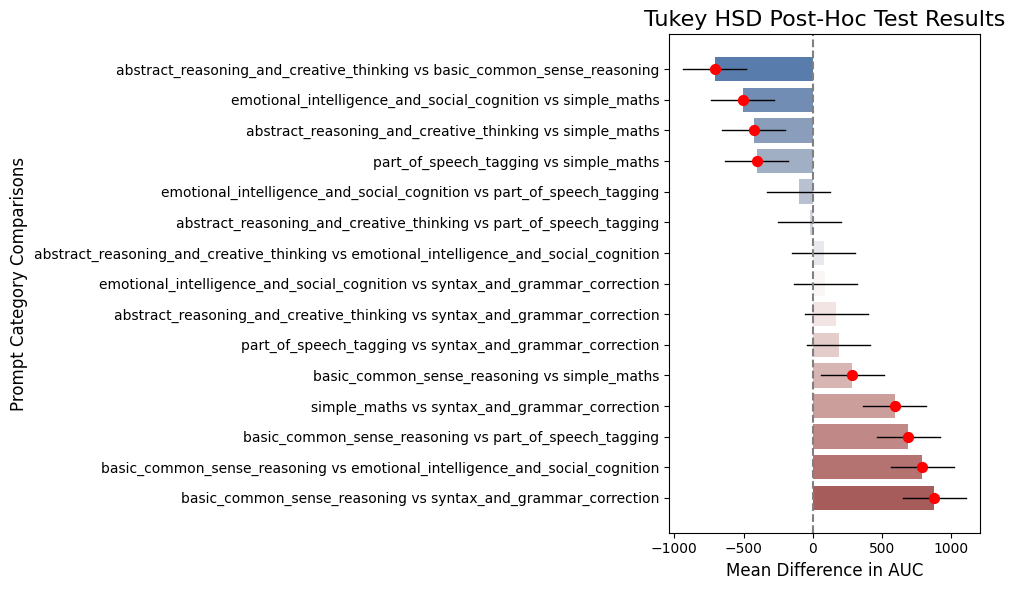

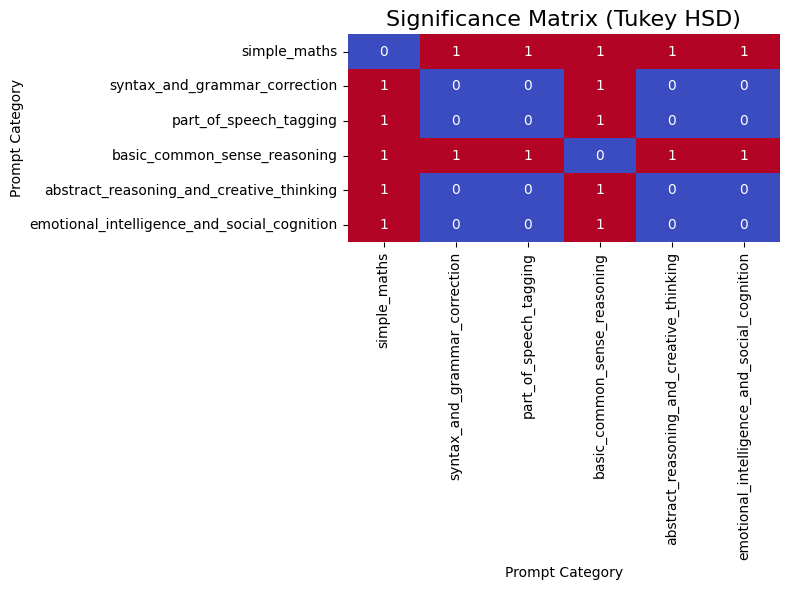

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np

# Assuming df_anova is your dataframe with 'Prompt_Category' and 'AUC'
# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=df_anova['AUC'], groups=df_anova['Prompt_Category'], alpha=0.05)

# Convert the Tukey results into a DataFrame for easier plotting
tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])

# Rename columns for convenience
tukey_df.columns = ['group1', 'group2', 'meandiff', 'p-adj', 'lower', 'upper', 'reject']

# Sort the DataFrame by mean difference for better plotting
tukey_df = tukey_df.sort_values('meandiff')

# Create a new column to combine group1 and group2 for labeling
tukey_df['Comparison'] = tukey_df['group1'] + ' vs ' + tukey_df['group2']

# --- Part 1: Tukey HSD Bar Plot Visualization ---

# Set up the figure for the bar plot
plt.figure(figsize=(10, 6))

# Create a horizontal bar plot for mean differences
sns.barplot(x='meandiff', y='Comparison', data=tukey_df, palette='vlag')

# Add the confidence intervals as error bars
for i in range(tukey_df.shape[0]):
    plt.plot([tukey_df['lower'].iloc[i], tukey_df['upper'].iloc[i]], [i, i], color='black', lw=1)

# Mark significant comparisons
for i in range(tukey_df.shape[0]):
    if tukey_df['reject'].iloc[i]:
        plt.scatter(tukey_df['meandiff'].iloc[i], i, color='red', s=50, zorder=3)

# Customize the plot
plt.axvline(x=0, color='grey', linestyle='--', label='No Difference')
plt.title('Tukey HSD Post-Hoc Test Results', fontsize=16)
plt.xlabel('Mean Difference in AUC', fontsize=12)
plt.ylabel('Prompt Category Comparisons', fontsize=12)
plt.tight_layout()


# Save the plot into a file
save_dir = constants.PLOT_ABLATIONS + constants.ABLATIONS_RANKING_METHOD + '/' + '4-Meaningfulness_of_Prompt_Categories/'
os.makedirs(save_dir, exist_ok=True)
plt.savefig(save_dir + '1-Turkey_HSD_Bar_Plot.png')

# Show the plot
plt.show()

# --- Part 2: Significance Matrix (Heatmap) ---

# Get unique prompt categories
categories = df_anova['Prompt_Category'].unique()

# Create an empty matrix to store the significance values (True or False)
significance_matrix = np.zeros((len(categories), len(categories)), dtype=bool)

# Populate the matrix based on Tukey HSD results
for i, group1 in enumerate(categories):
    for j, group2 in enumerate(categories):
        if group1 != group2:
            # Check if group1 vs group2 exists in Tukey results (in either order)
            row = tukey_df[(tukey_df['group1'] == group1) & (tukey_df['group2'] == group2) |
                           (tukey_df['group1'] == group2) & (tukey_df['group2'] == group1)]
            if not row.empty:
                significance_matrix[i, j] = row['reject'].values[0]

# Create a heatmap to visualize the significance matrix
plt.figure(figsize=(8, 6))
sns.heatmap(significance_matrix, annot=True, fmt="d", cmap="coolwarm", xticklabels=categories, yticklabels=categories, cbar=False)

# Customize the heatmap
plt.title('Significance Matrix (Tukey HSD)', fontsize=16)
plt.xlabel('Prompt Category')
plt.ylabel('Prompt Category')

# Rotate the x labels to 45 degrees (you can adjust this angle)
# plt.xticks(rotation=45)

plt.tight_layout()

# Save the figure
plt.savefig(save_dir + '2-Significance_Matrix_Heatmap.png')

# Show the plot
plt.show()



#### Bootstrap Resampling for Confidence Intervals

In [67]:
def bootstrap_mean_diff(x, y, n_bootstrap=1000):
    observed_diff = np.mean(x) - np.mean(y)
    boot_diffs = []
    combined = np.concatenate([x, y])
    n = len(x)
    for _ in range(n_bootstrap):
        boot_sample = np.random.choice(combined, size=2*n, replace=True)
        boot_x = boot_sample[:n]
        boot_y = boot_sample[n:]
        boot_diff = np.mean(boot_x) - np.mean(boot_y)
        boot_diffs.append(boot_diff)
    return observed_diff, np.percentile(boot_diffs, [2.5, 97.5])

bootstrap_results = {}

for prompt_category, data in auc_results.items():
    synergy_aucs = data['synergy']
    # Flatten random AUCs
    random_aucs = [auc for sublist in data['random'] for auc in sublist]

    observed_diff, ci = bootstrap_mean_diff(synergy_aucs, random_aucs)
    bootstrap_results[prompt_category] = {
        'observed_diff': observed_diff,
        'confidence_interval': ci
    }
    print(f"Prompt Category: {prompt_category}")
    print(f"Observed Difference in Mean AUC: {observed_diff:.4f}")
    print(f"95% Confidence Interval: [{ci[0]:.4f}, {ci[1]:.4f}]\n")


Prompt Category: simple_maths
Observed Difference in Mean AUC: 159.8102
95% Confidence Interval: [-72.7460, 70.6573]

Prompt Category: syntax_and_grammar_correction
Observed Difference in Mean AUC: 72.1229
95% Confidence Interval: [-51.6222, 51.0779]

Prompt Category: part_of_speech_tagging
Observed Difference in Mean AUC: 129.0392
95% Confidence Interval: [-61.6373, 61.2082]

Prompt Category: basic_common_sense_reasoning
Observed Difference in Mean AUC: 99.1876
95% Confidence Interval: [-56.0566, 55.7528]

Prompt Category: abstract_reasoning_and_creative_thinking
Observed Difference in Mean AUC: 84.0264
95% Confidence Interval: [-47.7949, 51.4500]

Prompt Category: emotional_intelligence_and_social_cognition
Observed Difference in Mean AUC: 42.9555
95% Confidence Interval: [-248.0734, 251.3493]



#### Visualize the Results


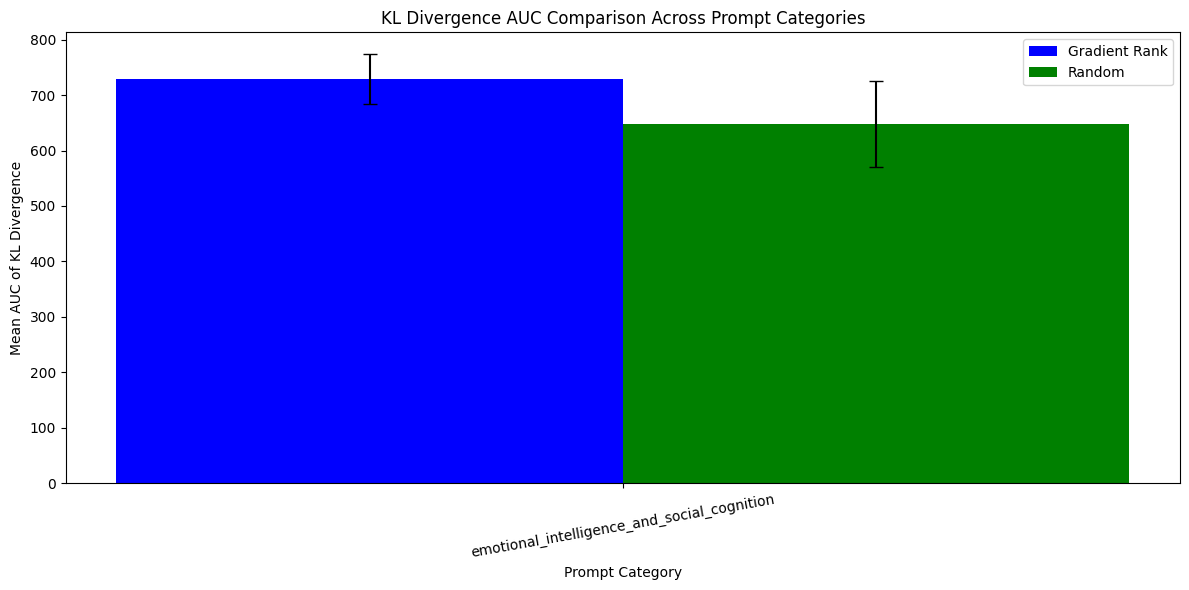

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Create a larger plot to compare all prompt categories
prompt_categories = list(mean_auc_results.keys())
num_categories = len(prompt_categories)

# Create arrays for mean AUC values and standard deviations
mean_synergy_aucs = [mean_auc_results[cat]['mean_synergy_auc'] for cat in prompt_categories]
mean_random_aucs = [mean_auc_results[cat]['mean_random_auc'] for cat in prompt_categories]
std_synergy_aucs = [np.std(mean_auc_results[cat]['synergy_aucs']) for cat in prompt_categories]
std_random_aucs = [np.std(mean_auc_results[cat]['random_aucs']) for cat in prompt_categories]

# Bar width
bar_width = 0.35
index = np.arange(num_categories)

# Create a larger figure
plt.figure(figsize=(12, 6))

# Plot bars for synergy and random ablations
bars_synergy = plt.bar(index, mean_synergy_aucs, bar_width, yerr=std_synergy_aucs,
                       label='Gradient Rank', capsize=5, color='blue')

bars_random = plt.bar(index + bar_width, mean_random_aucs, bar_width, yerr=std_random_aucs,
                      label='Random', capsize=5, color='green')

# Add labels and title
plt.xlabel('Prompt Category')
plt.ylabel('Mean AUC of KL Divergence')
plt.title('KL Divergence AUC Comparison Across Prompt Categories')

# Set x-axis tick labels
plt.xticks(index + bar_width / 2, prompt_categories, rotation=10)

# Add legend
plt.legend()

# Annotate p-values above the bars
for i, prompt_category in enumerate(prompt_categories):
    p_value = p_values[prompt_category]['p_value']
    p_value_smaller_than_alpha = p_value < 0.001
    p_value_print = f"p-value < 0.001" if p_value_smaller_than_alpha else f"p-value = {p_value:.4f}"
    
    # Add p-value annotations above the bars for synergy
    # plt.text(i, mean_synergy_aucs[i] + std_synergy_aucs[i] + 0.02, p_value_print,
    #          ha='center', fontsize=10, color='red')

# Show the final plot
plt.tight_layout()

# Save the plot into a file
save_dir = constants.PLOT_ABLATIONS + constants.ABLATIONS_RANKING_METHOD + '/' + '2-KL_Divergence_AUC_Comparison_Across_Prompt_Categories/' 
os.makedirs(save_dir, exist_ok=True)
plt.savefig(save_dir + 'KL_Divergence_AUC_Comparison_Across_Prompt_Categories.png')

plt.show()


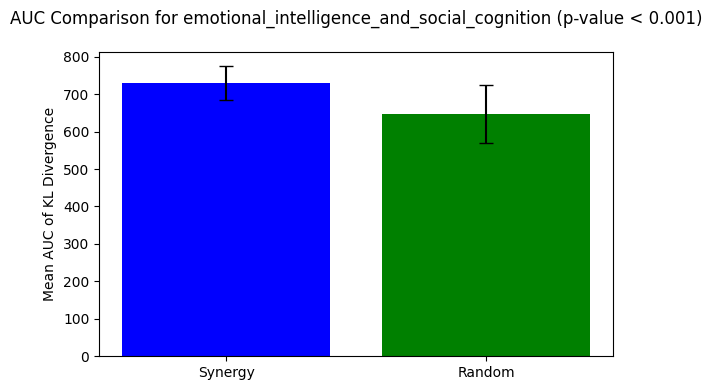

In [17]:
import matplotlib.pyplot as plt
import os

# Assuming we already have `mean_auc_results` and `p_values` from previous steps
for prompt_category, data in mean_auc_results.items():
    mean_synergy_auc = data['mean_synergy_auc']
    mean_random_auc = data['mean_random_auc']
    std_synergy = np.std(data['synergy_aucs'])
    std_random = np.std(data['random_aucs'])

    # Get p-value from t-test results
    p_value = p_values[prompt_category]['p_value']

    # Create bar plot
    plt.figure(figsize=(6, 4))
    plt.bar(['Synergy', 'Random'], [mean_synergy_auc, mean_random_auc],
            yerr=[std_synergy, std_random], capsize=5, color=['blue', 'green'])
    
    # Add labels and title
    plt.ylabel('Mean AUC of KL Divergence')
    
    # Add the p-value in the title or as an annotation
    p_value_smaller_than_alpha = p_value < 0.001
    p_value_print = f"p-value < 0.001" if p_value_smaller_than_alpha else f"p-value = {p_value: .4f}"
    plt.title(f'AUC Comparison for {prompt_category} ({p_value_print})', pad=20)  # Increase padding for the title
    
    # Adjust layout to prevent cutoff of titles, labels, etc.
    plt.tight_layout()

    # Save the plot with bbox_inches='tight' to ensure all content is included
    save_dir = constants.PLOT_ABLATIONS + constants.ABLATIONS_RANKING_METHOD + '/' + '3-KL_Divergence_AUC_Comparison_Per_Prompt_Category/' 
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(save_dir + prompt_category + '.png', bbox_inches='tight')  # Use bbox_inches='tight' to ensure nothing is cut off

    # Show plot
    plt.show()


## Raw Attention and Time Series Generation

In [4]:
time_series = {cognitive_task: {} for cognitive_task in constants.PROMPT_CATEGORIES}

print("Loading Raw Attention and Time Series")
for cognitive_task in constants.PROMPT_CATEGORIES:
    print("Loading Cognitive Task: ", cognitive_task)
    for n_prompt, prompt in enumerate(constants.PROMPTS[cognitive_task]):
        time_series[cognitive_task][n_prompt] = load_time_series(base_load_path=constants.TIME_SERIES_DIR+cognitive_task+"/"+str(n_prompt) + ".pt")
        plot_attention_metrics_norms_over_time(time_series[cognitive_task][n_prompt], metrics=constants.METRICS_TRANSFORMER, num_heads_plot=8, smoothing_window=0, 
            save=constants.SAVE_PLOTS, base_plot_path=constants.PLOTS_TIME_SERIES_DIR+cognitive_task+"/"+str(n_prompt)+"/")

Loading Raw Attention and Time Series
Loading Cognitive Task:  simple_maths


/vol/bitbucket/pu22/Synergy_Redundancy_LLMs/src/time_series_generation.py:206: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(base_load_path)


Loading Cognitive Task:  syntax_and_grammar_correction
Loading Cognitive Task:  part_of_speech_tagging
Loading Cognitive Task:  basic_common_sense_reasoning
Loading Cognitive Task:  abstract_reasoning_and_creative_thinking
Loading Cognitive Task:  emotional_intelligence_and_social_cognition


### Random Time Series Generation

In [5]:
# Example usage
n_steps = 100  # Number of time steps
n_dim = (constants.NUM_LAYERS, constants.NUM_HEADS_PER_LAYER)  # Shape of the state vector
scale_factor = 0.9  # Scaling factor for stability
wishart_df = np.prod(n_dim) + 1  # Degrees of freedom for the Wishart distribution
seed = None  # Seed for reproducibility
value_range = (0, 1)  # Range to scale the time series values
correlation_strength = 0.001  # Strength of the correlation between components

random_time_series = generate_time_series(n_steps, n_dim, scale_factor, wishart_df, seed, value_range, correlation_strength)
print(random_time_series.shape)

random_time_series = {"random_walk_time_series": random_time_series}
plot_attention_metrics_norms_over_time(random_time_series, metrics=["random_walk_time_series"], num_heads_plot=8, 
    save=True, base_plot_path=constants.PLOTS_TIME_SERIES_DIR+'random_walk_time_series'+"/")

save_time_series(random_time_series, base_save_path=constants.TIME_SERIES_DIR+"random_walk_time_series.pt")

torch.Size([28, 24, 100])


## $\Phi$ ID Computations

### Plot All Synergy and Redundancy Matrices

In [ ]:
def plot_synergy_matrix(synergy_matrix, title, ax, vmin, vmax):
    cax = ax.matshow(synergy_matrix, cmap='viridis', vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xlabel('Attention Head')
    ax.set_ylabel('Attention Head')
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_label_position('bottom')
    return cax

def plot_all_synergy_matrices(synergy_matrices, base_plot_path=None, save=True):
    categories = constants.PROMPT_CATEGORIES
    num_categories = len(categories)
    rows, cols = 3, 2  # 3x2 matrix

    for metric in constants.METRICS_TRANSFORMER:
        # Find global min and max for color scaling
        all_values = np.concatenate([synergy_matrices[category][metric].flatten() for category in categories])
        vmin, vmax = all_values.min(), all_values.max()

        fig, axs = plt.subplots(rows, cols, figsize=(15, 10))
        fig.subplots_adjust(right=0.8)  # Adjust subplots to leave space for the colorbar
        cax = None
        for i, category in enumerate(categories):
            row, col = divmod(i, cols)
            synergy_matrix = synergy_matrices[category][metric]
            cax = plot_synergy_matrix(synergy_matrix, category, axs[row, col], vmin, vmax)
        
        # Create a single colorbar
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])  # [left, bottom, width, height]
        fig.colorbar(cax, cax=cbar_ax)

        if save:
            if base_plot_path is None:
                base_plot_path = constants.PLOTS_SYNERGY_REDUNDANCY_DIR + 'all_synergy_matrices/'
            plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust layout to fit colorbar
            os.makedirs(base_plot_path, exist_ok=True)
            plt.savefig(os.path.join(base_plot_path, metric + '.png'))
        else:
            plt.show()
        plt.close()
# plot_all_synergy_matrices(synergy_matrices, save=True)


### Plot PhiID Matrices given time_series Dictionary

In [ ]:
ranks_per_layer_mean = {cognitive_task: {} for cognitive_task in constants.PROMPT_CATEGORIES}
ranks_per_layer_std = {cognitive_task: {} for cognitive_task in constants.PROMPT_CATEGORIES}
global_matrices = {cognitive_task: {} for cognitive_task in constants.PROMPT_CATEGORIES}
synergy_matrices = {cognitive_task: {} for cognitive_task in constants.PROMPT_CATEGORIES}
redundancy_matrices = {cognitive_task: {} for cognitive_task in constants.PROMPT_CATEGORIES}

for prompt_category_name in constants.PROMPT_CATEGORIES:
    print("Plotting Prompt Category: ", prompt_category_name,)
    for n_prompt, prompt in enumerate(constants.PROMPTS[prompt_category_name]):
        print("Prompt Number: ", n_prompt)

    
        global_matrices[prompt_category_name][n_prompt], synergy_matrices[prompt_category_name][n_prompt], redundancy_matrices[prompt_category_name][n_prompt] = load_matrices(base_save_path=constants.MATRICES_DIR + prompt_category_name + '/' + str(n_prompt) + '.pt')
        plot_synergy_redundancy_PhiID( synergy_matrices[prompt_category_name][n_prompt], redundancy_matrices[prompt_category_name][n_prompt], 
                                      save=constants.SAVE_PLOTS, base_plot_path=constants.PLOTS_SYNERGY_REDUNDANCY_DIR + prompt_category_name + '/' + str(n_prompt) + '/')
        plot_all_PhiID(global_matrices[prompt_category_name][n_prompt], save=constants.SAVE_PLOTS, base_plot_path=constants.PLOTS_SYNERGY_REDUNDANCY_DIR + prompt_category_name + '/' + str(n_prompt) + '/')
        plot_all_PhiID_separately(global_matrices[prompt_category_name][n_prompt], save=constants.SAVE_PLOTS, base_plot_path=constants.PLOTS_SYNERGY_REDUNDANCY_DIR + prompt_category_name + '/' + str(n_prompt) + '/')

        base_plot_path = constants.PLOTS_SYNERGY_REDUNDANCY_DIR + prompt_category_name + '/' + str(n_prompt) + '/'
        averages = calculate_average_synergy_redundancies_per_head(synergy_matrices[prompt_category_name][n_prompt], redundancy_matrices[prompt_category_name][n_prompt], 
                                                                   within_layer=False)
        plot_averages_per_head(averages, save=constants.SAVE_PLOTS, use_heatmap=True, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER, base_plot_path=base_plot_path)
        plot_averages_per_layer(averages, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER)
        gradient_ranks = compute_gradient_rank(averages)
        plot_gradient_rank(gradient_ranks, base_plot_path=base_plot_path, save=constants.SAVE_PLOTS, use_heatmap=True, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER)
        ranks_per_layer_mean[prompt_category_name], ranks_per_layer_std[prompt_category_name] = plot_average_ranks_per_layer(gradient_ranks, save=constants.SAVE_PLOTS, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER, base_plot_path=base_plot_path)

        # Graph Theoretical Analysis
        graph_theoretical_results = load_graph_theoretical_results(base_save_path=constants.GRAPH_METRICS_DIR + prompt_category_name + '/', file_name=str(n_prompt))
        plot_graph_theoretical_results(graph_theoretical_results, save=constants.SAVE_PLOTS, base_plot_path=base_plot_path)

### Compute the Sum of the Different PhiID atoms along the Matrices of the Different Categories

In [ ]:
phid_atoms = list(global_matrices["simple_maths"][0]["attention_weights"].keys())
global_sums = {phid_atom: {} for phid_atom in phid_atoms}
metric = "attention_weights"

for phid_atom in phid_atoms:
    for prompt_category_name in constants.PROMPT_CATEGORIES:
        global_sums[phid_atom][prompt_category_name] = 0
        for n_prompt, prompt in enumerate(constants.PROMPTS[prompt_category_name]):
            global_sums[phid_atom][prompt_category_name] += global_matrices[prompt_category_name][n_prompt][metric][phid_atom].sum()

for phid_atom in phid_atoms:
    # Plot Synergy and Redundancy SUms as a function of the cognitive task  
    plt.figure(figsize=(10, 5))
    plt.bar(global_sums[phid_atom].keys(), global_sums[phid_atom].values(), color='blue', alpha=0.7, label=phid_atom)
    plt.xlabel('Cognitive Task')
    plt.ylabel(f'Sum of {phid_atom}')
    plt.title(f'Sum of {phid_atom}')
    plt.legend()
    plt.tight_layout()
    plt.show()


### Synergy and Redundancy Plots for Concrete Prompt Category

In [ ]:
prompt_category_name = 'average_prompts'
print("\n--- Plotting Prompt Category: ", prompt_category_name, " ---")

global_matrices, synergy_matrices, redundancy_matrices = load_matrices(base_save_path=constants.MATRICES_DIR + prompt_category_name + '/' + prompt_category_name + '.pt')
plot_synergy_redundancy_PhiID(synergy_matrices, redundancy_matrices, save=constants.SAVE_PLOTS, base_plot_path=constants.PLOTS_SYNERGY_REDUNDANCY_DIR + prompt_category_name + '/')
plot_all_PhiID(global_matrices, save=constants.SAVE_PLOTS, base_plot_path=constants.PLOTS_SYNERGY_REDUNDANCY_DIR + prompt_category_name + '/')
results_all_phid = plot_all_PhiID_separately({"attention_weights": global_matrices["attention_weights"]}, save=constants.SAVE_PLOTS, base_plot_path=constants.PLOTS_SYNERGY_REDUNDANCY_DIR + prompt_category_name + '/')
plot_box_plot_information_dynamics(results_all_phid, atom_or_dynamics="dynamics", save=constants.SAVE_PLOTS, base_plot_path=constants.PLOTS_SYNERGY_REDUNDANCY_DIR + prompt_category_name + '/')
plot_box_plot_information_dynamics(results_all_phid, atom_or_dynamics="atoms", save=constants.SAVE_PLOTS, base_plot_path=constants.PLOTS_SYNERGY_REDUNDANCY_DIR + prompt_category_name + '/')

base_plot_path = constants.PLOTS_SYNERGY_REDUNDANCY_DIR + prompt_category_name + '/'
averages = calculate_average_synergy_redundancies_per_head(synergy_matrices, redundancy_matrices, within_layer=False)
plot_averages_per_head(averages, save=constants.SAVE_PLOTS, use_heatmap=True, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER, base_plot_path=base_plot_path)
plot_averages_per_layer(averages, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER)
gradient_ranks = compute_gradient_rank(averages)
plot_gradient_rank(gradient_ranks, base_plot_path=base_plot_path, save=constants.SAVE_PLOTS, use_heatmap=True, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER)
ranks_per_layer_mean, ranks_per_layer_std = plot_average_ranks_per_layer(gradient_ranks, save=constants.SAVE_PLOTS, num_heads_per_layer=constants.NUM_HEADS_PER_LAYER, base_plot_path=base_plot_path)

# Graph Theoretical Analysis
graph_theoretical_results = load_graph_theoretical_results(base_save_path=constants.GRAPH_METRICS_DIR + prompt_category_name + '/', file_name=prompt_category_name)
plot_graph_theoretical_results(graph_theoretical_results, save=constants.SAVE_PLOTS, base_plot_path=base_plot_path)

### Final Gradient Ranks Overlay Plots Accross Models

In [5]:
final_models_gradient_ranks = load_final_models_gradient_ranks()
plot_gradient_rank_overlay(final_models_gradient_ranks, save=True, plot_intralayer_std=False, figsize=(16,6))


### Plots Random Walk Time Series

In [ ]:
prompt_category_name = 'random_walk_time_series'
print("\n--- Plotting Prompt Category: ", prompt_category_name, " ---")

global_matrices, synergy_matrices, redundancy_matrices = load_matrices(base_save_path=constants.MATRICES_DIR + prompt_category_name + '.pt')
plot_synergy_redundancy_PhiID(synergy_matrices, redundancy_matrices, save=constants.SAVE_PLOTS, base_plot_path=constants.PLOTS_SYNERGY_REDUNDANCY_DIR + prompt_category_name + '/')
plot_all_PhiID(global_matrices, save=constants.SAVE_PLOTS, base_plot_path=constants.PLOTS_SYNERGY_REDUNDANCY_DIR + prompt_category_name + '/')
results_all_phid = plot_all_PhiID_separately(global_matrices, save=constants.SAVE_PLOTS, base_plot_path=constants.PLOTS_SYNERGY_REDUNDANCY_DIR + prompt_category_name + '/')
plot_box_plot_information_dynamics(results_all_phid, atom_or_dynamics="dynamics", save=constants.SAVE_PLOTS, base_plot_path=constants.PLOTS_SYNERGY_REDUNDANCY_DIR + prompt_category_name + '/')
plot_box_plot_information_dynamics(results_all_phid, atom_or_dynamics="atoms", save=constants.SAVE_PLOTS, base_plot_path=constants.PLOTS_SYNERGY_REDUNDANCY_DIR + prompt_category_name + '/')

base_plot_path = constants.PLOTS_SYNERGY_REDUNDANCY_DIR + prompt_category_name + '/'
averages = calculate_average_synergy_redundancies_per_head(synergy_matrices, redundancy_matrices, within_layer=False)
plot_averages_per_head(averages, save=constants.SAVE_PLOTS, use_heatmap=True, constants.NUM_HEADS_PER_LAYER=constants.NUM_HEADS_PER_LAYER, base_plot_path=base_plot_path)
# plot_averages_per_layer(averages, constants.NUM_HEADS_PER_LAYER=constants.NUM_HEADS_PER_LAYER)
gradient_ranks = compute_gradient_rank(averages)
plot_gradient_rank(gradient_ranks, base_plot_path=base_plot_path, save=constants.SAVE_PLOTS, use_heatmap=True, constants.NUM_HEADS_PER_LAYER=constants.NUM_HEADS_PER_LAYER)
ranks_per_layer_mean, ranks_per_layer_std = plot_average_ranks_per_layer(gradient_ranks, save=constants.SAVE_PLOTS, constants.NUM_HEADS_PER_LAYER=constants.NUM_HEADS_PER_LAYER, base_plot_path=base_plot_path)

# Graph Theoretical Analysis
graph_theoretical_results = load_graph_theoretical_results(base_save_path=constants.GRAPH_METRICS_DIR + prompt_category_name + '/', file_name=prompt_category_name)
plot_graph_theoretical_results(graph_theoretical_results, save=constants.SAVE_PLOTS, base_plot_path=base_plot_path)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


plot_box_plot_information_dynamics(results_all_phid, atom_or_dynamics="dynamics")
plot_box_plot_information_dynamics(results_all_phid, atom_or_dynamics="atoms")

In [ ]:
# Prepare the data for the first condition
data_1 = pd.DataFrame(information_dynamics_dict)
data_1['Condition'] = 'Random Time Series'  # Add a column for the condition

# Prepare the data for the second condition
data_2 = pd.DataFrame(information_dynamics_dict_average)
data_2['Condition'] = 'Average Prompts'  # Add a column for the condition

# Concatenate the two DataFrames
df_combined = pd.concat([data_1, data_2], ignore_index=True)

# Melt the DataFrame to have a long format
df_melted = df_combined.melt(id_vars='Condition', var_name='Information Dynamic', value_name='Values')

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Information Dynamic', y='Values', hue='Condition', data=df_melted)

# Add titles and labels
plt.title('Box Plot of Information Dynamics for Two Conditions')
plt.xlabel('Information Dynamic')
plt.ylabel('Values')

# Show the plot
plt.show()

## Different Heads for Different Cognitive Tasks

### Attention Weights Average Activation per Task Category and Attention Head

In [35]:
base_plot_path = constants.PLOTS_HEAD_ACTIVATIONS_COGNITIVE_TASKS

print("Loading Attention Weights")
attention_weights_prompts =  load_attention_weights()

# print("Plotting Attention Weights")
# summary_stats_prompts = plot_categories_comparison(attention_weights_prompts, save=constants.SAVE_PLOTS, base_plot_path=base_plot_path, split_half=False, split_third=False)
# plot_all_heatmaps(attention_weights_prompts, save=constants.SAVE_PLOTS, base_plot_path=base_plot_path)

Loading Attention Weights


### LDA Analysis of the Attention Weights

In [36]:
perform_lda_analysis(attention_weights_prompts, save=constants.SAVE_PLOTS, base_plot_path=base_plot_path)

## Synergy Redundancy and Task Correlations

### Regression plots of Average Activation vs Layer

In [12]:
results = plot_all_category_diffs_vs_syn_red_grad_rank(summary_stats_prompts, gradient_ranks[constants.ATTENTION_MEASURE], ranks_per_layer_mean,
        save=constants.SAVE_PLOTS, reorder=False, per_layer=True, constants.NUM_HEADS_PER_LAYER=constants.NUM_HEADS_PER_LAYER, baseline_rest=False)

### Categories Correlation: Relative Activation vs Gradient Rank Correlations

In [27]:
compute_and_plot_gradient_activations_correlation(results_all_phid, summary_stats_prompts, per_layer=False, save=constants.SAVE_PLOTS, base_plot_path=None)
compute_and_plot_gradient_activations_correlation(results_all_phid, summary_stats_prompts, per_layer=True, save=constants.SAVE_PLOTS, base_plot_path=None)

### Average Rank of Most Significantly Activated Heads by Category

In [14]:
plot_rank_most_activated_heads_per_task(summary_stats_prompts, gradient_ranks, top_ns=[1,3,5,10,30, 50], save=constants.SAVE_PLOTS)

### Top Synergistic and Top Redundant Heads

In [ ]:
plot_most_syn_red_tasks(summary_stats_prompts, gradient_ranks[constants.ATTENTION_MEASURE], top_n=10)

### Average Head Activation per Task

In [ ]:
plot_average_head_activation_per_task(summary_stats_prompts)